In [1]:
import pandas as pd
import requests
import json
from pprint import pp
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#spark = SparkSession.builder.appName("loanapi").getOrCreate()

In [6]:
url= 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response= requests.get(url)
r= response.json()
print(response)

<Response [200]>


In [7]:

df_loan= pd.DataFrame(r)
df_loan.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


In [9]:
spark = SparkSession.builder.appName('loaninfo').getOrCreate()

In [10]:
spdf_loan=spark.createDataFrame(df_loan)
spdf_loan.show(5)

c:\Users\12242\python_practice\Etlloan_project\cap_env\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
c:\Users\12242\python_practice\Etlloan_project\cap_env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|


In [6]:
spdf_loan.printSchema()

root
 |-- Application_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Application_Status: string (nullable = true)



In [11]:
spdf_loan.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()


Find and plot the percentage of applications approved for self-employed applicants.

+-------------+-------+
|self_employed|Percent|
+-------------+-------+
|           No|  86.74|
|          Yes|  13.26|
+-------------+-------+



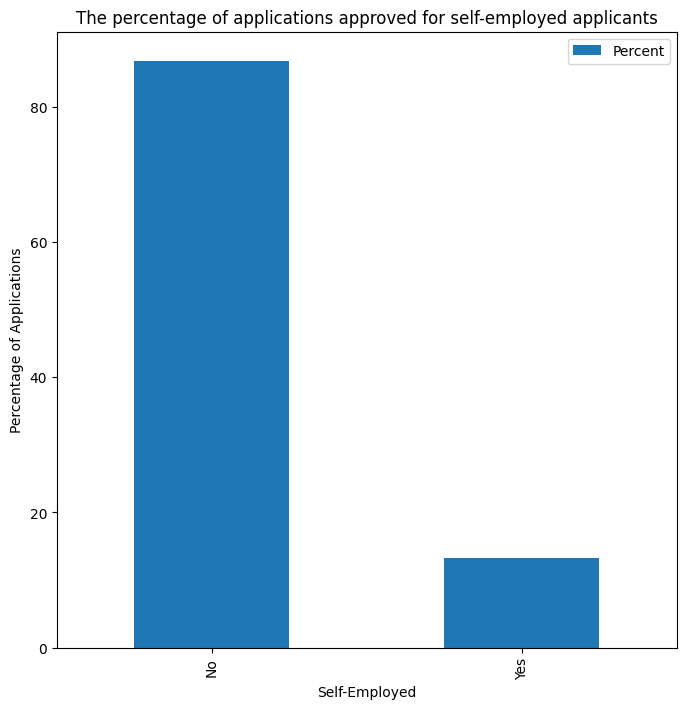

In [12]:
query = "(SELECT self_employed, \
                (round(count(application_status)/(SELECT COUNT(Application_ID) FROM cdw_sapp_loan_application \
                WHERE application_status = 'Y')*100, 2) ) as Percent \
                FROM cdw_sapp_loan_application \
                WHERE Application_status = 'Y' \
                GROUP BY self_employed, application_status) as e"

sp_sql1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query) \
  .load()

sp_sql1.show()
sploanDF=sp_sql1.toPandas()
# pd_sql1.reset_index(inplace=True)
# sploanDF['Percent'] = sploanDF['Percent'].astype('float')
# sploanDF.plot(kind='bar', x='self_employed', y='Percent', figsize=(8,8))
# plt.title('The percentage of applications approved for self-employed applicants')
# plt.xlabel('Self-Employed')
# plt.ylabel('Percentage of Applications')
# plt.show()


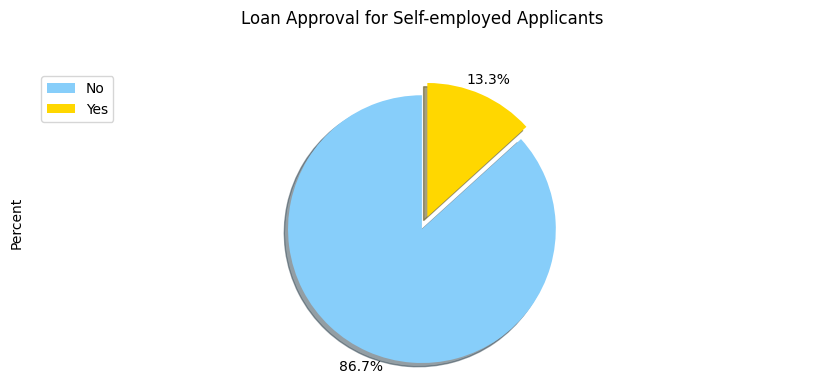

In [31]:
colors_list = ['lightskyblue', 'gold']
explode_list = [0.1, 0] # ratio for each continent with which to offset each wedge.
sploanDF['Percent'].plot(kind='pie',
                            figsize=(10, 4),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title('Loan Approval for Self-employed Applicants', y=1.12) 
plt.axis('equal') 
# add legend
plt.legend(labels=sploanDF["self_employed"], loc='upper left') 
plt.show()

In [12]:
sploanDF['Percent'] = sploanDF['Percent'].astype('float')
sploanDF.head()

,self_employed,Percent
0,No,86.74
1,Yes,13.26


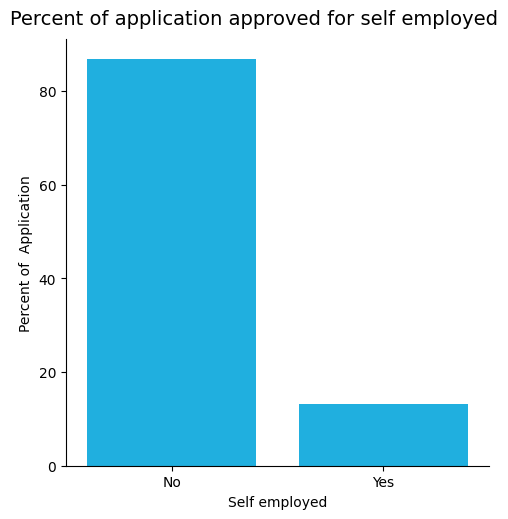

In [25]:
g = sns.catplot(data=sploanDF, x='self_employed', y="Percent", kind='bar', sharey = False,
           color = 'deepskyblue')
g.set_axis_labels("Self employed", "Percent of  Application")
#g.set_titles("{col_name}")
g.fig.suptitle('Percent of application approved for self employed', y=1.03, fontsize=14)
g.set_xticklabels(rotation = 0)


2.Find the percentage of rejection for married male applicants.

+------------------+------------------+-------+
|application_status|count_applications|Percent|
+------------------+------------------+-------+
|                 N|                87|  28.43|
|                 Y|               219|  71.57|
+------------------+------------------+-------+



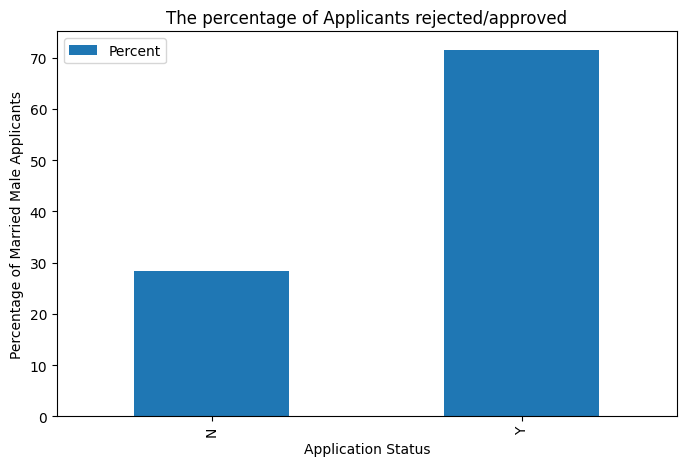

In [35]:
query2 = "(SELECT application_status, COUNT(application_status) AS count_applications, \
		(round(count(application_status)/(SELECT COUNT(*) FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' )*100,2)) AS Percent \
		FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' \
		GROUP BY application_status) as a"

sp_sql2 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query2) \
  .load()

sp_sql2.show()
pd_vis2 = sp_sql2.toPandas()
# pd_sql1.reset_index(inplace=True)
pd_vis2['Percent'] = pd_vis2['Percent'].astype('float')
pd_vis2.plot(kind='bar', x='application_status', y='Percent', figsize=(8,5))
plt.title('The percentage of Applicants rejected/approved')
plt.xlabel('Application Status')
plt.ylabel('Percentage of Married Male Applicants')
plt.show()


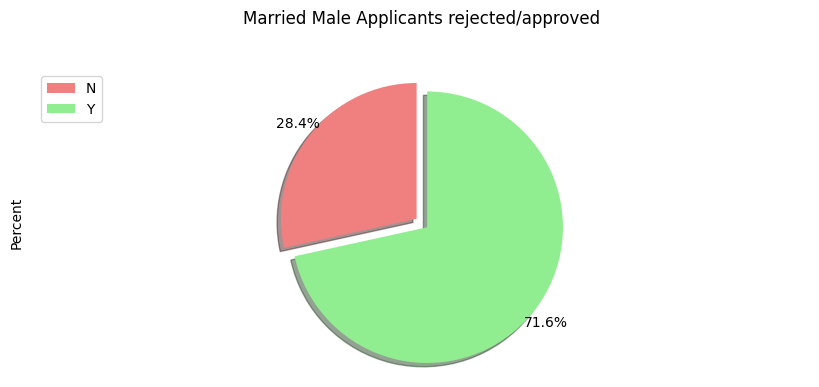

In [45]:
colors_list = ['lightcoral', 'lightgreen']
explode_list = [0, 0.1] # ratio for each continent with which to offset each wedge.
pd_vis2['Percent'].plot(kind='pie',
                            figsize=(10, 4),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title('Married Male Applicants rejected/approved', y=1.12)
plt.axis('equal') 
# add legend
plt.legend(labels=pd_vis2["application_status"], loc='upper left') 
plt.show()

Data shows loan rejection for Married Male applicants are significantly lower.

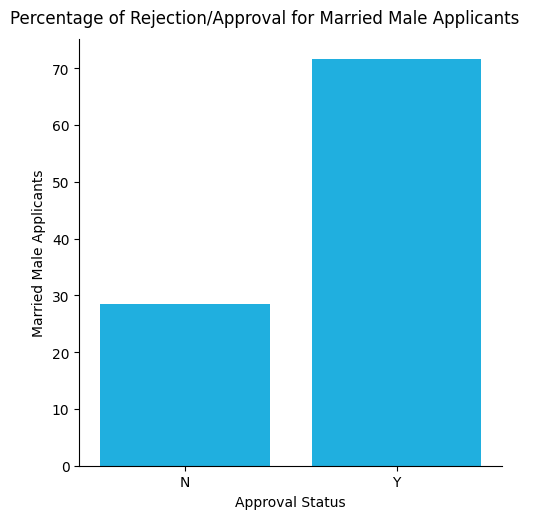

In [42]:

g = sns.catplot(data=pd_vis2,  x='application_status', y='Percent', kind='bar', sharey = False,
           color = 'deepskyblue')
g.set_axis_labels("Approval Status", "Married Male Applicants")
#g.set_titles("{col_name}")
g.fig.suptitle('Percentage of Rejection/Approval for Married Male Applicants ', y=1.03, fontsize=12)
g.set_xticklabels(rotation = 0)


3.Find and plot the top three months with the largest transaction data.

In [4]:
query3 = "(SELECT MONTHNAME(timeid) AS Month, round(sum(TRANSACTION_value),2) AS Transaction_value \
            FROM cdw_sapp_credit_card \
            GROUP BY substr(timeid,1,6) \
            ORDER BY sum(TRANSACTION_value) DESC \
            LIMIT 3) as a"

sp_sql3 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query3) \
  .load()

sp_sql3.show()
pd_sql3 = sp_sql3.toPandas()

# pd_sql3.plot(kind='line', x='Month', y='Transaction_value',marker='o', figsize=(8,5))
# plt.title('Top 3 Months Transactions')
# plt.ylabel('Total Transaction')
# plt.xlabel('Month')
# plt.show()


+--------+-----------------+
|   Month|Transaction_value|
+--------+-----------------+
| October|        405167.78|
|     May|        402620.52|
|December|        402502.16|
+--------+-----------------+



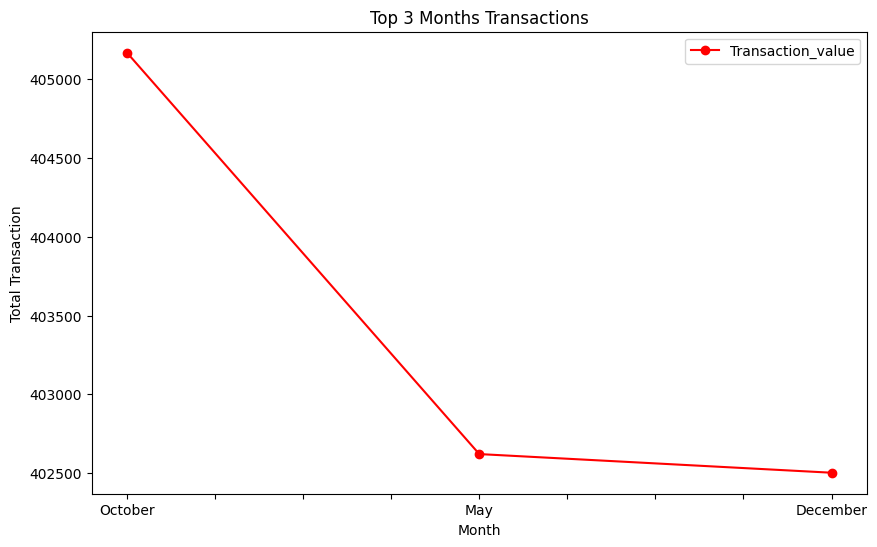

In [10]:
pd_sql3.plot(kind='line',x='Month', y='Transaction_value',marker='o',color='red',figsize=(10,6))
plt.title('Top 3 Months Transactions')
plt.ylabel('Total Transaction')
plt.xlabel('Month')
plt.show()


In [ ]:
# plt.xticks(ticks=[1,3,5,7,9,11])
# df_mtotal.plot(lw=3,linestyle='dotted',marker='o',color='red',xlim=0,ylim=100000,figsize=(10,6))
# plt.legend( loc ="lower right")
# plt.xticks(ticks=df_mtotal.index.to_list())
# plt.plot(x, y, linestyle='-.',color='green',marker='o',markersize=10,alpha=0.7)
# plt.legend(["Weight in kg"],loc ="lower right")

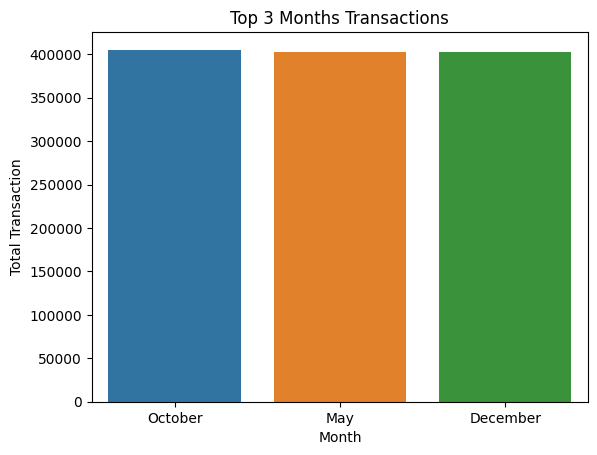

In [59]:
sns.barplot(x='Month', y='Transaction_value', data=pd_sql3)
plt.title('Top 3 Months Transactions')
plt.ylabel('Total Transaction')
plt.xlabel('Month')
plt.show()

Find and plot which branch processed the highest total dollar value of healthcare transactions.


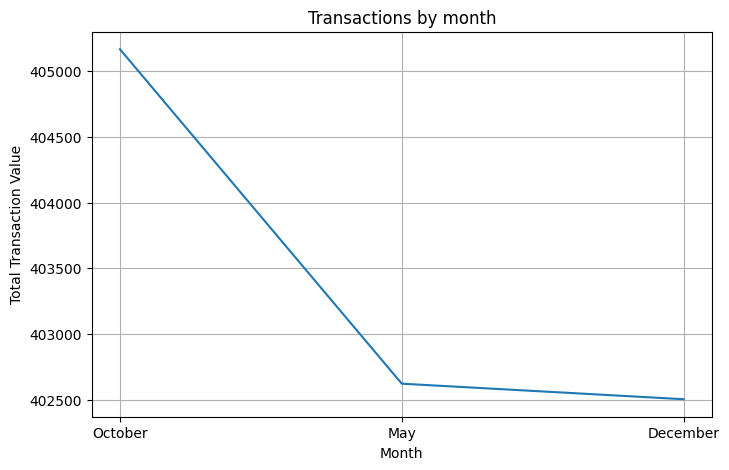

In [64]:
# plot a line plot
# plt.figure(figsize=[15,5])
# sns.lineplot(data=weekday_avg_min, x='day_of_week', y='duration_min',marker='o')
# plt.ylabel('Average Duration (min)');
# plt.xlabel('Day of The Week')
# plt.grid()
# plt.title('Average Trip Duration Based on The Day of The Week')
# plt.show()
plt.figure(figsize=[8,5])
sns.lineplot(data=pd_sql3, x='Month', y='Transaction_value')
plt.ylabel('Total Transaction Value')
plt.xlabel('Month')
plt.grid()
plt.title('Transactions by month')
plt.show()



In [ ]:

query4 = "(SELECT branch_code, round(SUM(transaction_value),2) AS Total_Transaction_Value  \
            FROM cdw_sapp_credit_card \
            WHERE transaction_type = 'Healthcare'\
            group by branch_code \
            ORDER BY SUM(transaction_value) DESC \
            LIMIT 5) as a"

sp_sql4 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query4) \
  .load()
#sp_sql4.show()

pd_sql4 = sp_sql4.toPandas()
pd_sql4['Transaction_value'] = pd_sql4['Total_Transaction_Value'].astype('float')
#pd_sql4.plot(kind='bar', x='branch_code', y='Total_Transaction_Value', figsize=(8,5))
# plt.title('highest total dollar value of healthcare transactions by Branch code')
# plt.ylabel('Total Transaction Value')
# plt.xlabel('branch Code')
# plt.show()



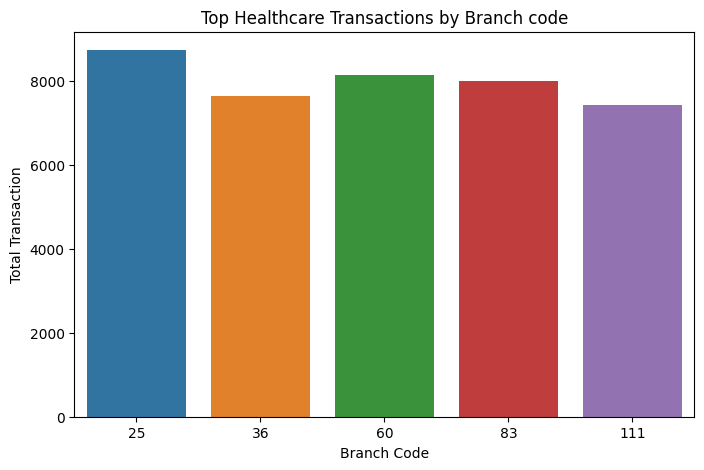

In [63]:
plt.figure(figsize=[8,5])
sns.barplot(x='branch_code', y='Total_Transaction_Value', data=pd_sql4)
plt.title('Top Healthcare Transactions by Branch code')
plt.ylabel('Total Transaction')
plt.xlabel('Branch Code')
plt.show()